In [12]:
%matplotlib inline

In [62]:
from typing import List, Union

from qiskit import pulse
from qiskit.pulse.reschedule import pad
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.pulse import Schedule, DriveChannel, MeasureChannel, FrameChange, Delay

import numpy as np

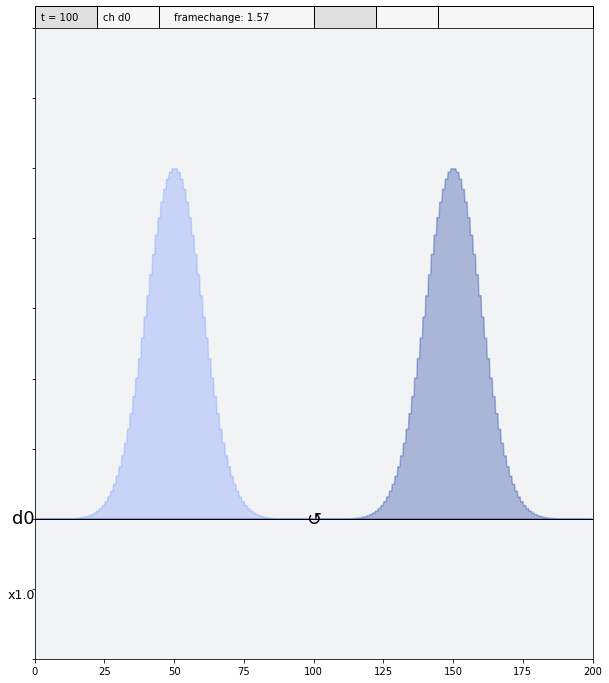

In [32]:
sched = Schedule()
f = pulse_lib.gaussian(100, 1.0, 10.0)
sched += f(DriveChannel(0))
sched += FrameChange(np.pi/2)(DriveChannel(0))
sched |= f(DriveChannel(0)).shift(100)
sched.draw()

# Align left

In [42]:
def align_left(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the left
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    for instruction in instructions:
        aligned += instruction
    
    return aligned


def align_right(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the left
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    left_aligned = align_left(*instructions)
    max_channel_duration = 0
    
    for channel in left_aligned.channels:
        aligned_channel = left_aligned.filter(channels=[channel])
        duration = max(aligned_channel.duration, duration)

    max_duration = 0
    for channel in left_aligned.channels:
        aligned_channel = left_aligned.filter(channels=[channel])
        channel_duration= aligned_channel.duration
        delay = max_duration - channel_duration
        
    
    return aligned
    
        

In [60]:
ramsey = pulse.Schedule()
x90 = pulse_lib.gaussian_square(100, 0.5j, 50, 20)
ramsey += x90(DriveChannel(0))
ramsey += Delay(100)(DriveChannel(0))
ramsey += x90(DriveChannel(0))
align = [f(DriveChannel(0)), f(DriveChannel(0)), ramsey, f(DriveChannel(1))]

PulseInstruction(SamplePulse(samples=array([1.05249048e-06+0.j, 4.07442931e-06+0.j, 8.88048510e-06+0.j, ...,
       8.88048510e-06+0.j, 4.07442931e-06+0.j, 1.05249048e-06+0.j]), name="p15"), DriveChannel(0))
PulseInstruction(SamplePulse(samples=array([1.05249048e-06+0.j, 4.07442931e-06+0.j, 8.88048510e-06+0.j, ...,
       8.88048510e-06+0.j, 4.07442931e-06+0.j, 1.05249048e-06+0.j]), name="p15"), DriveChannel(0))
Schedule((0, PulseInstruction(SamplePulse(samples=array([0.+0.02376006j, 0.+0.06974047j, 0.+0.11362439j, ...,
       0.+0.11362439j, 0.+0.06974047j, 0.+0.02376006j]), name="p20"), DriveChannel(0))), (100, DelayInstruction(Delay(duration=100, name="delay5"), DriveChannel(0))), (200, PulseInstruction(SamplePulse(samples=array([0.+0.02376006j, 0.+0.06974047j, 0.+0.11362439j, ...,
       0.+0.11362439j, 0.+0.06974047j, 0.+0.02376006j]), name="p20"), DriveChannel(0))), name="")
PulseInstruction(SamplePulse(samples=array([1.05249048e-06+0.j, 4.07442931e-06+0.j, 8.88048510e-06+0.j, ..

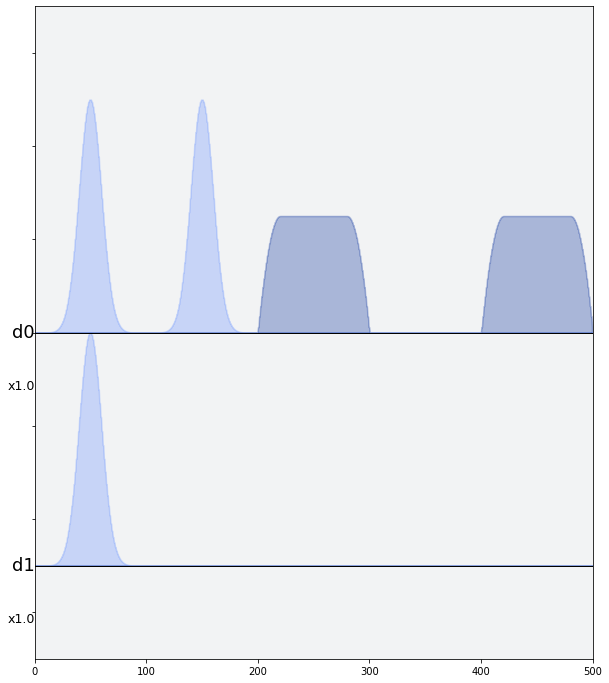

In [61]:
aligned_left = align_left(*align)
aligned_left.draw()